# Deep Mining of States from System Executions

We try to infer system states by learning the behavior and anaylzing the resulting neural space

We start by importing the necessary packages

In [1]:
from random import random
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from matplotlib import pyplot

Using TensorFlow backend.


# Generating input data

First, we need to write some input data. Therefore, we define a function

In [2]:
def createSample(size):
    input = np.zeros(shape=(size))
    output = np.zeros(shape=(size))
    state = 0
    rand = np.array([random() for _ in range(size)])
    for i in range(size):
        if rand[i]>0.95:
            input[i] = 1
            output[i] = state
            state = (state + 1) % 2
        else:
            input[i] = 0
            output[i] = state
    sample = pd.DataFrame({'input': input, 'output': output})
    return sample

Let's see what this creates

In [3]:
print(createSample(50))

    input  output
0     0.0     0.0
1     0.0     0.0
2     0.0     0.0
3     0.0     0.0
4     0.0     0.0
5     0.0     0.0
6     0.0     0.0
7     0.0     0.0
8     0.0     0.0
9     0.0     0.0
10    0.0     0.0
11    0.0     0.0
12    0.0     0.0
13    0.0     0.0
14    0.0     0.0
15    0.0     0.0
16    0.0     0.0
17    0.0     0.0
18    0.0     0.0
19    0.0     0.0
20    1.0     0.0
21    0.0     1.0
22    0.0     1.0
23    0.0     1.0
24    1.0     1.0
25    0.0     0.0
26    0.0     0.0
27    0.0     0.0
28    0.0     0.0
29    0.0     0.0
30    0.0     0.0
31    0.0     0.0
32    0.0     0.0
33    0.0     0.0
34    0.0     0.0
35    0.0     0.0
36    0.0     0.0
37    0.0     0.0
38    0.0     0.0
39    1.0     0.0
40    0.0     1.0
41    0.0     1.0
42    0.0     1.0
43    0.0     1.0
44    0.0     1.0
45    0.0     1.0
46    0.0     1.0
47    0.0     1.0
48    0.0     1.0
49    0.0     1.0


# Data from State Machines

Now we create some data from a coffee machine modeled as state machine. Therefore, we import a state machine simulation

In [2]:
import StateMachineSimulation as sm

Now, let's run the coffee machine

In [3]:
input = ["coin-5","tea", "coin-10", "coffee", "coin-5", "coin-5", "coffee", "coin-10", "tea"]

In [6]:
cvm = sm.getCVM()
output = cvm.run(input)

Record the run in a DataFrame

In [7]:
trace = pd.DataFrame({'input': input,'output':output})

Let's look at the trace

In [8]:
print(trace)

     input              output
0   coin-5                    
1      tea            cupOfTea
2  coin-10                    
3   coffee         cupOfCoffee
4   coin-5                    
5   coin-5                    
6   coffee         cupOfCoffee
7  coin-10                    
8      tea  cupOfTea, return-5


# Define a BILSTM model

This is how you define a bidirectiona LSTM model in Keras.
* `n_units` is the number of neuron per layer
* `n_layers` is the number of lstm layers
* `inputshape` is the input shape of the data (lstm demands an input shape of form `(timesteps,input_dim)`)
* `mode` is the mode to be used for aggregating the bisirectional lstms. Default is `concat`.

In [4]:
def get_bilstm_model(n_layers, n_units, inputshape, mode):
    model = Sequential()
    model.add(Bidirectional(LSTM(n_units, return_sequences=True), input_shape=inputshape))
    for _ in range(n_layers-1):
        model.add(Bidirectional(LSTM(n_units, return_sequences=True)))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return(model)

# Train the model

First, we define a function that trains a model in 1000 epochs, creating a unique sample every epoch. The performance over the epoches is stored in the `loss` object.

In [14]:
def train_model(model, timesteps):
  loss = list()
  for _ in range(1000):
    data = createSample(timesteps)
    X_Train = np.array(data['input'])
    X_Train = X_Train.reshape(1,timesteps,1)
    Y_Train = np.array(data['output'])
    Y_Train = Y_Train.reshape(1,timesteps,1)
    hist = model.fit(X_Train,Y_Train,epochs = 1, batch_size = 1, verbose = 1)
    loss.append(hist.history['loss'][0])
  return loss

Let's try to train a model on 10 timesteps with 10 units in the BILSTM layer.

In [17]:
timesteps = 50
layers = 3
units = 128
model = get_bilstm_model(layers,units,(timesteps,1),'concat')
result = pd.DataFrame({'bilstm': train_model(model,timesteps)})

Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 0.6927 - acc: 0.9000
Epoch 1/1
1/1 [==============================] - 0s 161ms/step - loss: 0.6933 - acc: 0.5600
Epoch 1/1
1/1 [==============================] - 0s 201ms/step - loss: 0.6620 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 148ms/step - loss: 0.6590 - acc: 0.8000
Epoch 1/1
1/1 [==============================] - 0s 160ms/step - loss: 0.5722 - acc: 0.9600
Epoch 1/1
1/1 [==============================] - 0s 160ms/step - loss: 0.7317 - acc: 0.5600
Epoch 1/1
1/1 [==============================] - 0s 164ms/step - loss: 0.7998 - acc: 0.4600
Epoch 1/1
1/1 [==============================] - 0s 211ms/step - loss: 0.7222 - acc: 0.5800
Epoch 1/1
1/1 [==============================] - 0s 153ms/step - loss: 0.9210 - acc: 0.1200
Epoch 1/1
1/1 [==============================] - 0s 165ms/step - loss: 0.5570 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 158ms/step - loss: 0.6549 - acc

KeyboardInterrupt: 

Let's have a look at the loss progression

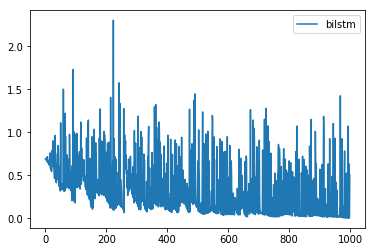

In [16]:
result.plot()
pyplot.show()